In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import scipy.stats

sys.path.insert(0, str(Path().absolute().parents[1]))

from cv_prince.chap_07_complex_densities.gaussians import Gaussian
from cv_prince.chap_07_complex_densities.student import ExpectationMaximisationStudent
from notebooks.utils import create_cov_based_on_angle_and_axis_scale

In [8]:
# Create a Gaussian with outliers
num_samples = 10000
outliers_rate = 0.001
num_outliers = int(num_samples * outliers_rate)
rng = np.random.default_rng(seed=12345)

# Sample inliers
mean = np.array((1.0, 4.0))
cov = create_cov_based_on_angle_and_axis_scale(30, (1, 1 / 8))
gaussian = Gaussian(mean=mean, cov=cov)

samples = gaussian.sample(n=num_samples - num_outliers, rng=rng)

# Sample outliers
samples_min = samples.min(axis=0)
samples_max = samples.max(axis=0)
samples_extent = samples_max - samples_min

outliers = np.empty((0, 2), dtype=np.float64)
while outliers.shape[0] < num_outliers:
    current_outliers = rng.uniform(
        low=samples_min - 0.5 * samples_extent,
        high=samples_max + 0.5 * samples_extent,
        size=(num_outliers - outliers.shape[0], 2),
    )

    mah_dist = gaussian.mahalanobis_dist(current_outliers)
    current_outliers = current_outliers[
        mah_dist > 5, :
    ]  # Make sure we only keep actual outliers
    outliers = np.concat([outliers, current_outliers], axis=0)

# Combine all samples
all_samples = np.concat([samples, outliers], axis=0)

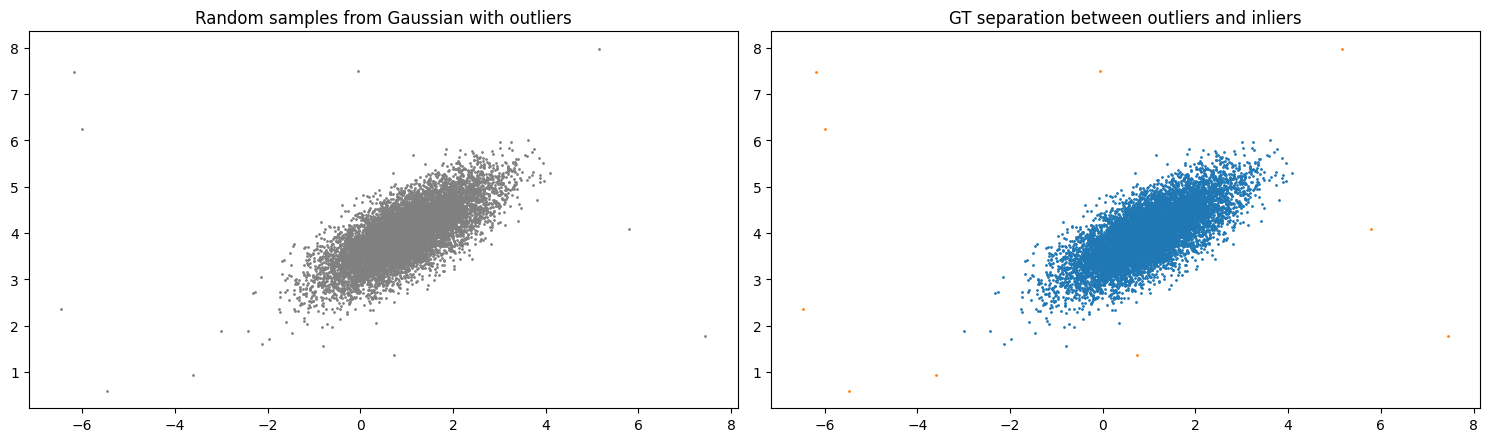

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(all_samples[:, 0], all_samples[:, 1], s=1, color="gray")
axes[0].set_title("Random samples from Gaussian with outliers")
axes[0].set_aspect("equal")

axes[1].scatter(samples[:, 0], samples[:, 1], s=1)
axes[1].scatter(outliers[:, 0], outliers[:, 1], s=1)
axes[1].set_title("GT separation between outliers and inliers")
axes[1].set_aspect("equal")

fig.tight_layout()

In [10]:
em_fitter = ExpectationMaximisationStudent(seed=12345)
em_fitter.fit(all_samples, max_iter=1000)

 40%|███▉      | 398/1000 [00:00<00:00, 869.38it/s]


In [11]:
print(em_fitter)

GMM with the following parameters 
* mean: 
[0.985 3.992] 

* cov : 
[[0.7   0.342]
 [0.342 0.317]] 

* nu  : 
17.618428401614736 



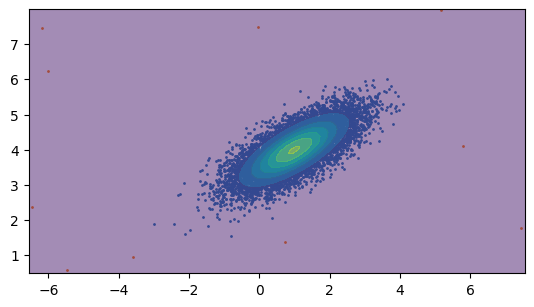

In [12]:
rv_fitted = scipy.stats.multivariate_t(
    loc=em_fitter.mean, shape=em_fitter.cov, df=em_fitter.nu
)

all_samples_min = all_samples.min(axis=0)
all_samples_max = all_samples.max(axis=0)

x, y = np.meshgrid(
    np.arange(all_samples_min[0] - 0.1, all_samples_max[0] + 0.1, 0.1),
    np.arange(all_samples_min[1] - 0.1, all_samples_max[1] + 0.1, 0.1),
)
coords = np.stack([x, y], axis=-1)

fig, ax = plt.subplots(1, 1)
ax.set_aspect("equal")
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.scatter(outliers[:, 0], outliers[:, 1], s=1)
plt.contourf(x, y, rv_fitted.pdf(coords), alpha=0.5)